In [1]:
# CAP 5415 Programming Assignment 03: Autoencoder

"""
Due Date: 1ONov2023
Author: Lam Nguyen

Subject: Autoencoder [2.5 pts]

Overview:

Implement autoencoder using MNIST dataset. The input size of the images will be 28x28 with a single channel. You will implement two different variations, one with fully connected layers and the other convolutional neural network.

Tasks:

1. Implement an autoencoder using fully connected layers. 
    a. The encoder will have 2 layers (with 256, and 128 neurons)
    b. The decoder will have 2 layers (with 256 and 784 neurons)
    c. Train this network using MSE loss for 10 epochs
    d. Compare the number of parameters  in the encoder and decoder.
    e. Create a writeup:
        i. Show 20 reconstructed images from testing data (2 image for each class)
        ii. Show original images

2. Implement an autoencoder using Convolutional layers. 
    a. The encoder will have 2 convolutional layers and 2 max pooling layers
        i. Use kernel size 3x3
        ii. reLU activation
        iii. padding of 1 to preserve the feature map.
    b. The decoder will have 3 convolutional layers
        i. kernel shape is 3x3
        ii. padding = 1
        iii. The first 2 convolutional layers will be followed by an upsampling layer.
                a. This upsampling layer will double the resolution of the feature maps using linear interpolation
    c. Train the network for 10 epochs
    d. Compare the number of parameters in the encoder and decoder.
    e. Compare the total parameters in this autoencoder with the previous autoencoder.
    f. Create Writeup:
        i. Show 20 sample reconstructed images from testing data (2 images for each class)
        ii. show original images
        iii. Compare the reconstructed results with the previous autoencoder

Note that you can choose any optimizer. Just use the same for both variations
        

Sources:

Autoencoder in Pytorch-Theory and Implementation by Patrick Loeber: https://www.youtube.com/watch?v=zp8clK9yCro

How to get info on model parameters using Torchinfo: https://pypi.org/project/torchinfo/

How to save trained model: https://wandb.ai/wandb/common-ml-errors/reports/How-to-Save-and-Load-Models-in-PyTorch--VmlldzozMjg0MTE

How to take subsets of dataset: https://discuss.pytorch.org/t/how-to-get-a-part-of-datasets/82161



"""

'\nDue Date: 1ONov2023\nAuthor: Lam Nguyen\n\nSubject: Autoencoder [2.5 pts]\n\nOverview:\n\nImplement autoencoder using MNIST dataset. The input size of the images will be 28x28 with a single channel. You will implement two different variations, one with fully connected layers and the other convolutional neural network.\n\nTasks:\n\n1. Implement an autoencoder using fully connected layers. \n    a. The encoder will have 2 layers (with 256, and 128 neurons)\n    b. The decoder will have 2 layers (with 256 and 784 neurons)\n    c. Train this network using MSE loss for 10 epochs\n    d. Compare the number of parameters  in the encoder and decoder.\n    e. Create a writeup:\n        i. Show 20 reconstructed images from testing data (2 image for each class)\n        ii. Show original images\n\n2. Implement an autoencoder using Convolutional layers. \n    a. The encoder will have 2 convolutional layers and 2 max pooling layers\n        i. Use kernel size 3x3\n        ii. reLU activation\n  

In [2]:
# ========================================================================================#
# 1. Load Modules
# ========================================================================================#

import torch
from pathlib import Path
from PIL import Image
import os
import numpy as np
from torchvision.utils import save_image
import torch.optim as optim # Optimization algorithms
import torch.nn as nn # All the Neural network models, loss functions
import torch.nn.functional as F # All functions without parameters
from torch.utils.data import DataLoader # Easier dataset management such as minibatches
import torchvision.datasets as datasets # Standard datasets that can be used as test training data
import torchvision.transforms as transforms # Transformations that can be performed on the dataset
import torchvision.utils
from torchinfo import summary # provides a summary of the model architecture and it's parameters
import logging
import matplotlib.pyplot as plt

# Import some packages for logging training and showing progress
from tqdm_loggable.auto import tqdm



# Set up some basic logging to record traces of training
logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        filename="Autoencoder_Documents/Autoencoder_Parameter_Summary.txt" # Save log to a file
    )


# Hyperparameters
input_size = 28*28
hidden_size = 100
num_classes= 10
learning_rate = 1e-3
batch_size = 64
num_epochs = 10
weight_decay = 1e-5
    


# Load GPU Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/lamcnguyen/Softwaredev/anaconda3/anaconda3/envs/deeplearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# =======================================================#
# 2. Import Data:
# =======================================================#

train_dataset = datasets.MNIST(root='MNIST_dataset/', 
               train=True, 
               transform=transforms.ToTensor(),
               download=True
               )#Transforms transforms numpy array to tensors so that pytorch can use the data


train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)


In [4]:
# =======================================================#
# 3. Create Fully Connected Autoencoder:
# =======================================================#

class FCC_Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=128),


        )

        self.decoder = nn.Sequential(
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Note: If images are in the range (-1,1) apply Tanh() activation instead of sigmoid


# Input [-1, +1] -> use nn.Tanh

In [5]:
# ========================================================================================#
# 3. Import the Fully Connected Autoencoder Model and train
# ========================================================================================#

model = FCC_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


outputs = []
for epoch in range(num_epochs):
    for (img, _) in tqdm(train_loader):
        img = img.to(device)
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

# =======================================================#
# 6. Save the trained Fully Connected Autoencoder
# =======================================================#

print("Saving the Fully Connected Autoencoder Model to the folder: Assignment_03/01_Autoencoder/Trained_Autoencoders")
torch.save(model.state_dict(),'Trained_Autoencoders/FCC_Autoencoder_Model.pth')


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:04<00:00, 226.61it/s]


Epoch:1, Loss:0.0140


100%|██████████| 938/938 [00:04<00:00, 227.86it/s]


Epoch:2, Loss:0.0092


100%|██████████| 938/938 [00:04<00:00, 230.62it/s]


Epoch:3, Loss:0.0088


100%|██████████| 938/938 [00:04<00:00, 229.25it/s]


Epoch:4, Loss:0.0069


100%|██████████| 938/938 [00:04<00:00, 228.62it/s]


Epoch:5, Loss:0.0064


100%|██████████| 938/938 [00:04<00:00, 230.01it/s]


Epoch:6, Loss:0.0072


100%|██████████| 938/938 [00:04<00:00, 229.52it/s]


Epoch:7, Loss:0.0069


100%|██████████| 938/938 [00:04<00:00, 228.59it/s]


Epoch:8, Loss:0.0067


100%|██████████| 938/938 [00:04<00:00, 228.49it/s]


Epoch:9, Loss:0.0066


100%|██████████| 938/938 [00:04<00:00, 229.68it/s]

Epoch:10, Loss:0.0048
Saving the Fully Connected Autoencoder Model to the folder: Assignment_03/01_Autoencoder/Trained_Autoencoders


In [6]:
# =======================================================#
# 5. Get the number of parameters for the FC-Autoencoder:
# =======================================================#

# Prints out the architecture of the trained model
FCC_Autoencoder_summary = summary(model)
print(FCC_Autoencoder_summary)

logging.info(FCC_Autoencoder_summary) # Saves the parameter data file into the folder Autoencoder_Documents


Layer (type:depth-idx)                   Param #
FCC_Autoencoder                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200,960
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       32,896
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       33,024
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       201,488
│    └─Sigmoid: 2-7                      --
Total params: 468,368
Trainable params: 468,368
Non-trainable params: 0


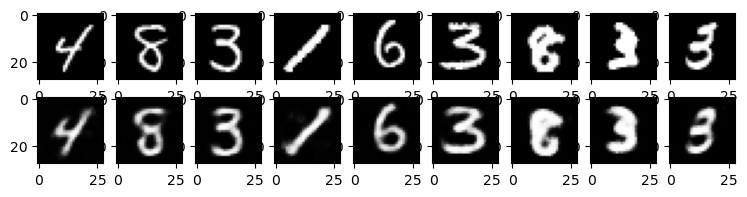

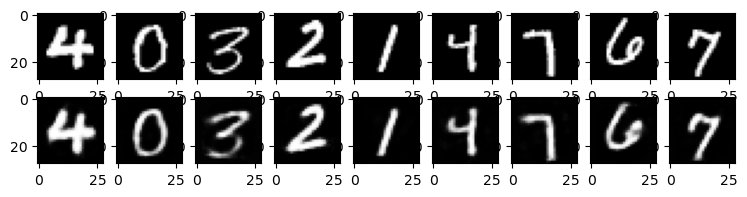

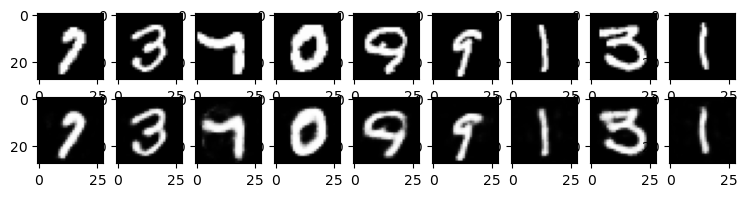

In [7]:

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [8]:
# =======================================================#
# 6. Save the trained Fully Connected Autoencoder
# =======================================================#

print("Saving the Fully Connected Autoencoder Model to the folder: Assignment_03/01_Autoencoder/Trained_Autoencoders")
torch.save(model.state_dict(),'Trained_Autoencoders/FCC_Autoencoder_Model.pth')


Saving the Fully Connected Autoencoder Model to the folder: Assignment_03/01_Autoencoder/Trained_Autoencoders


In [9]:
class CNN_Autoencoder_v2(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder_v2,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
class CNN_Autoencoder_v3(nn.Module):
    def __init__(self):
        #N,1,28,28
        super(CNN_Autoencoder_v3,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1) 
        )
        self.decoder = nn.Sequential(
            #nn.Upsample(scale_factor=2, mode='nearest'), 
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            #nn.Upsample(scale_factor=2, mode='nearest'), 
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=3, padding=1), 
            nn.ReLU(),
            #nn.Upsample(scale_factor=2,mode='nearest'), 
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=3, padding=1),
            nn.Tanh()
            
    )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [11]:
"""
Formula for ConvTranspose:

H_out = (H_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1

Formula for Conv:

H_out = ((H_in + 2 * padding - dilation*(kernel_size -1) - 1)/stride)   + 1


"""

"""

 a. The encoder will have 2 convolutional layers and 2 max pooling layers
        i. Use kernel size 3x3
        ii. reLU activation
        iii. padding of 1 to preserve the feature map.
    b. The decoder will have 3 convolutional layers
        i. kernel shape is 3x3
        ii. padding = 1
        iii. The first 3 convolutional layers will be followed by an upsampling layer.
                a. This upsampling layer will double the resolution of the feature maps using linear interpolation

"""


class CNN_Autoencoder_v4(nn.Module):
    def __init__(self):
        #N,1,28,28
        super(CNN_Autoencoder_v4,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="bilinear"), 
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.Tanh()
            
    )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
# ========================================================================================#
# 2. Import the Convolutional Autoencoder Model and train
# ========================================================================================#

model = CNN_Autoencoder_v4().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


outputs = []
for epoch in range(num_epochs):
    for (img, _) in tqdm(train_loader):

        img = img.to(device)
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

# =======================================================#
# Save the trained Convolutional Autoencoder
# =======================================================#


print("Saving the Convolutional Autoencoder Model to the folder: Assignment_03/01_Autoencoder/Trained_Autoencoders")
torch.save(model.state_dict(),'Trained_Autoencoders/CNN_Autoencoder_Model.pth')


100%|██████████| 938/938 [00:44<00:00, 20.96it/s]


Epoch:1, Loss:0.0313


100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


Epoch:2, Loss:0.0279


100%|██████████| 938/938 [00:44<00:00, 21.01it/s]


Epoch:3, Loss:0.0261


100%|██████████| 938/938 [00:44<00:00, 21.04it/s]


Epoch:4, Loss:0.0279


100%|██████████| 938/938 [00:44<00:00, 20.92it/s]


Epoch:5, Loss:0.0254


100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


Epoch:6, Loss:0.0243


100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


Epoch:7, Loss:0.0265


100%|██████████| 938/938 [00:44<00:00, 20.99it/s]


Epoch:8, Loss:0.0271


100%|██████████| 938/938 [00:44<00:00, 20.95it/s]


Epoch:9, Loss:0.0233


100%|██████████| 938/938 [00:44<00:00, 21.07it/s]

Epoch:10, Loss:0.0239
Saving the Convolutional Autoencoder Model to the folder: Assignment_03/01_Autoencoder/Trained_Autoencoders


In [13]:
# =======================================================#
# 5. Get the number of parameters for the CNN-Autoencoder:
# =======================================================#

# Prints out the architecture of the trained model
CNN_Autoencoder_summary = summary(model)
print(CNN_Autoencoder_summary)

logging.info(CNN_Autoencoder_summary) # Saves the parameter data file into the folder Autoencoder_Documents

Layer (type:depth-idx)                   Param #
CNN_Autoencoder_v4                       --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-7              4,624
│    └─ReLU: 2-8                         --
│    └─ConvTranspose2d: 2-9              1,160
│    └─ReLU: 2-10                        --
│    └─Upsample: 2-11                    --
│    └─ConvTranspose2d: 2-12             73
│    └─Tanh: 2-13                        --
Total params: 10,657
Trainable params: 10,657
Non-trainable params: 0


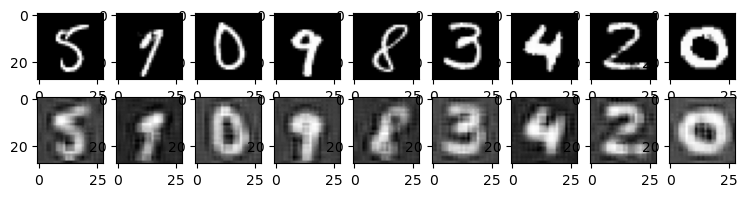

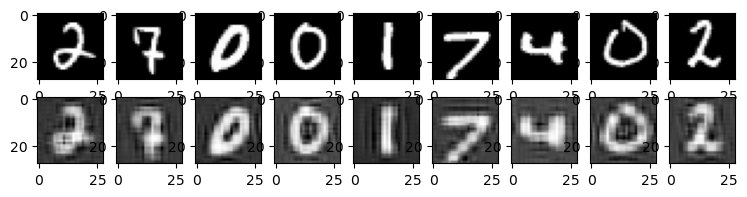

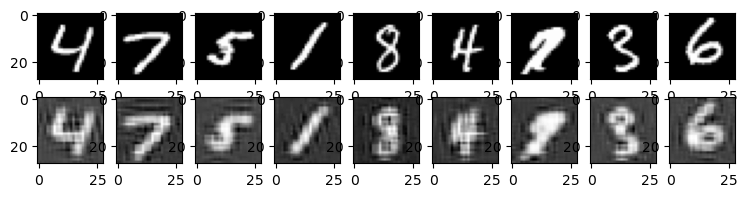

In [14]:


for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [15]:
# Input 20 images into CNN Autoencoder

input_images_array= Path("Test_Images").glob('*.png')

model = CNN_Autoencoder_v4().to(device)

model.load_state_dict(torch.load('Trained_Autoencoders/CNN_Autoencoder_Model.pth'))

model.eval()

for image in input_images_array:
    filename = os.path.basename(image).split('.',1)[0]
    im = Image.open(image).convert("L")
    im = np.asarray(im)
    convert_tensor = transforms.ToTensor()
    tensor_img = convert_tensor(im).to(device)
    tensor_img = tensor_img[None, :, : ,:]
    tensor_image = tensor_img.unsqueeze(0)


    with torch.no_grad():
        processed_img = model(tensor_img)
        print(processed_img.size())
        save_image(processed_img, f'Processed_CNN_Images/{filename}_processed.jpg')


# Why the hell are they coming out the wrong size?  
    




torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


/Users/lamcnguyen/Softwaredev/anaconda3/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [16]:
# Input 20 images into FCC Autoencoder

input_images_array= Path("Test_Images").glob('*.png')

model = FCC_Autoencoder().to(device)

model.load_state_dict(torch.load('Trained_Autoencoders/FCC_Autoencoder_Model.pth'))

model.eval()

for image in input_images_array:
    filename = os.path.basename(image).split('.',1)[0]
    im = Image.open(image).convert("L")
    im = np.asarray(im)
    convert_tensor = transforms.ToTensor()
    im = convert_tensor(im)
    im = im.to(device)
    im = im.reshape(-1,28*28)

    with torch.no_grad():
        processed_img = model(im)
        processed_img = processed_img.reshape(-1,28,28)
        print(processed_img.size())
        save_image(processed_img, f'Processed_FCC_Images/{filename}_processed.jpg')


    



torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
